In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost
# from autogluon.tabular import TabularDataset, TabularPredictor

import imodels
import sys
sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot
from rulevetting.projects.tbi_pecarn.baseline import Baseline


MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

C:\Users\hyunsuk\Anaconda3\lib\site-packages\redis\connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


# WRAPPING UP EVERYTHING

In [2]:

from rulevetting.projects.tbi_pecarn.eval_models import *

def train_models (model_type, simple = False, which_age = 'all', hyper_dict = {}, title_str = None) :
    '''
    model_type  : One of ['Logistic Regression', 'AdaBoost', 'LogitBoost', 'Decision Tree', 'SVM', 'RF'] - Which model to train
    which_age   : One of ['all', 'young', 'old']
    hyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)
    title_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")
    '''
    
    if model_type not in ['Logistic Regression', 'AdaBoost', 'LogitBoost', 'Decision Tree', 'SVM', 'RF'] :
        print("ERROR: model_type should be one of ['Logistic Regression', 'AdaBoost', 'LogitBoost', 'DecTree', 'SVM', 'RF']'")
        return
    
    # Dataset to use
    simple = simple    # 43 Columns or 120 Columns
    young = True
    old = True
    
    if which_age == 'young' :  #(6432 + 2144 + 2145 samples)
        old = False
    elif which_age == 'old' :  #(19025 + 6342 + 6432 samples)
        young = False

    df_train, df_tune, df_test = Dataset().get_data(simple = simple, young = young, old = old)
    outcome_def = 'outcome'
    
    X_train = df_train.drop(columns = outcome_def)
    y_train = df_train[outcome_def].values
    X_tune = df_tune.drop(columns = outcome_def)
    y_tune = df_tune[outcome_def].values
    
    # title_str
    ts = "ROC curve of " + model_type if title_str is None else title_str
    
    if model_type == 'Logistic Regression' :
        lv= hyper_dict['lamb_vec'] if 'lamb_vec' in hyper_dict.keys() else [0.05, 0.1, 0.2, 0.4, 0.7, 1, 1.3]
        return fit_eval_lr(X_train, y_train, X_tune, y_tune, ts, lamb_vec = lv)
    elif model_type == 'AdaBoost' :
        ne = hyper_dict['n_estimator'] if 'n_estimator' in hyper_dict.keys() else 100
        return fit_eval_boosted(X_train, y_train, X_tune, y_tune, ts, which_boost = 'AdaBoost', n_estimator = ne)
    elif model_type == 'LogitBoost' :    
        ne = hyper_dict['n_estimator'] if 'n_estimator' in hyper_dict.keys() else 100
        return fit_eval_boosted(X_train, y_train, X_tune, y_tune, ts, which_boost = 'LogitBoost', n_estimator = ne)
    elif model_type == 'Decision Tree' :
        de = hyper_dict['depth'] if 'depth' in hyper_dict.keys() else list(range(1, 6))
        wr = hyper_dict['weight_ratio'] if 'weight_ratio' in hyper_dict.keys() else [1, 100]
        return fit_eval_decTree(X_train, y_train, X_tune, y_tune, ts, depth = de , weight_ratio = wr)
    elif model_type == 'SVM' :
        gv = hyper_dict['gamma_vec'] if 'gamma_vec' in hyper_dict.keys() else [2**(-2), 2**(-1.5), 2**(-1), 2**(-0.5), 1, 2**(1)]
        return fit_eval_svm(X_train, y_train, X_tune, y_tune, ts, gamma_vec = gv)
    elif model_type == 'RF' :
        return fit_eval_rf(X_train, y_train, X_tune, y_tune, ts)             
                            


In [8]:
# Examples of using train_models funciton
'''
model_type  : One of ['Logistic Regression', 'AdaBoost', 'LogitBoost', 'DecTree', 'SVM', 'RF'] - Which model to train
which_age   : One of ['all', 'young', 'old']
hyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)
              
              Logistic Regression   - lamb_vec    : list of lambdas
              AdaBoost / LogitBoost - n_estimator : the number of weak learners
              Decision Tree         - depth       : max_depth of trees
                                    - weight_ratio: list of class weight ratio (non-tbi : 1, tbi : given weight)
              SVM                   - gamma_vec   : list of gammas
              
title_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")
'''
    
# Logistic Regression
#train_models (model_type = 'Logistic Regression', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'lambda_vec' : [0.5, 1, 1.5]})

# AdaBoost
#train_models (model_type = 'AdaBoost', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'n_estimator' : 100})

# LogitBoost
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    train_models (model_type = 'LogitBoost', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'n_estimator' : 100})

# Decision Tree
#train_models (model_type = 'Decision Tree', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'depth' : list(range(1, 6)), 'weight_ratio' : [1, 100]})

# SVM
#train_models (model_type = 'SVM', title_str = None, simple = False, 
#              which_age = 'all', hyper_dict = {'gamma_vec' : [0.5, 1]})

# RF
#train_models (model_type = 'RF', title_str = None, simple = False, which_age = 'all')





'\nmodel_type  : One of [\'Logistic Regression\', \'AdaBoost\', \'LogitBoost\', \'DecTree\', \'SVM\', \'RF\'] - Which model to train\nwhich_age   : One of [\'all\', \'young\', \'old\']\nhyper_dict  : Dictionary containing hyperparameter values to tune (See Examples below)\n              \n              Logistic Regression   - lamb_vec    : list of lambdas\n              AdaBoost / LogitBoost - n_estimator : the number of weak learners\n              Decision Tree         - depth       : max_depth of trees\n                                    - weight_ratio: list of class weight ratio (non-tbi : 1, tbi : given weight)\n              SVM                   - gamma_vec   : list of gammas\n              \ntitle_str   : Title for ROC curve (Default : "ROC curve of [MODEL_TYPE]")\n'

# WRAP-UP ENDS HERE

In [42]:

def predict_and_save(model, X_train, y_train, X_tune, y_tune, tune_only = False, save = True, model_name = 'decision_tree'):
    '''Plots cv and returns cv, saves all stats
    model     : Statistical model object
    tune_only : Boolean, whether getting stats for tuned data only or not
    save      : Boolean, save the result to pickle file or not
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        if tune_only and suffix == '_train' :
            continue
            
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    if save :
        pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes


def predict_stats(model, X_tune, y_tune,  min_sens = 0.95, verbose = True) :
    '''
    WRAPPER FOR predict_and_save function.
    
    Choose the threshold for probability which satisfies given sensitivity (min_sens),
    then prints AUC, accuracy, balanced accuracy, sensitivity, and specificity, NPV
    
    input
    ------
    model       : Statistical Model
    X_tune      : Data for tuning (validation)
    y_tune      : True outcome values
    min_sens    : minimum sensitivity to achieve
    verbose     : Print the statistics or not
    
    output
    ------
    Returns the dictionary containing statistics
    (AUC, accuracy, balanced accuracy, sensitivity, specificity, NPV)
    '''
  
    from sklearn.metrics import confusion_matrix
    
    y_pred_prob = model.predict_proba(X_tune)[:, 1]
    stats, threshes =  predict_and_save(model, X_tune, y_tune, X_tune, y_tune, tune_only = True, save = False, model_name = '')
    np.array(stats['sens']) > min_sens
    
    for i in range(len(stats['sens'])) :
        if stats['sens'][i] > min_sens : 
            continue
        thresh_val = threshes[max(0, i-1)]
        break
      
    y_tune_pred = np.array(y_pred_prob) > thresh_val

    # Confusion Matrix
    cm = confusion_matrix(y_tune, y_tune_pred, labels=[1, 0])
    
    # Calculating statistics
    n = sum(sum(cm))
    auc = roc_auc_score(y_tune, y_pred_prob)
    acc = (cm[0,0] + cm[1,1]) / n
    sens = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = cm[1,1] / (cm[1,0] + cm[1,1])
    npv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    balacc = (sens + spec) / 2
    
    if verbose :
        print('Confusion Matrix : \n', cm)
        print(f'Prob. threshold : {thresh_val:.5f}')
        print(f'AUC             : {auc:.3f}')  
        print(f'Accuracy        : {acc:.3f}')
        print(f'Sensitivity     : {sens:.3f}')
        print(f'Specificity     : {spec:.3f}')
        print(f'Balanced Acc.   : {balacc:.3f}')
        print(f'NPV             : {npv:.3f}')

    return {'AUC' : auc, 'Accuracy' : acc, 'Balanced Accuracy' : balacc, 
            "Sensitivity" : sens, "Specificity" : spec, "NPV" : npv}

# Data Generation

In [3]:
##################
# DATA SELECTION #
##################

simple = False    # 43 Columns or 120 Columns
young = True    # Include Age < 2                  (6432 + 2144 + 2145 samples)
old = True       # Include Age > 2                  (19025 + 6342 + 6432 samples)


df_train, df_tune, df_test = Dataset().get_data(simple = simple, young = young, old = old)
outcome_def = 'outcome'
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


# Baseline implementation

In [43]:
def add_binary_variables(data) :
    
    df = data.copy()
    
    df['HemaBinary'] = np.maximum.reduce([df['HemaLoc_Occipital'], df['HemaLoc_Parietal/Temporal']])
    df['LocBinary'] = np.maximum.reduce([df['LocLen_5 sec - 1 min'], df['LocLen_1-5 min'], df['LocLen_>5 min']])
    df['MechBinary'] = df['High_impact_InjSev_High']
    df['HABinary'] = df['HASeverity_Severe']
    df['SeizLen'] = np.maximum.reduce([df['SeizLen_1-5 min'], df['SeizLen_5-15 min'], df['SeizLen_>15 min']])
    df['HemaSizeBinary'] = np.maximum.reduce([df['HemaSize_Large'], df['HemaSize_Medium']])
    df['LocSeparateBinary'] = np.maximum.reduce([df['LOCSeparate_Suspected'], df['LOCSeparate_Yes']])
    df['SFxPalpBinary'] = np.maximum.reduce([df['SFxPalp_Unclear'], df['SFxPalp_Yes']])
    
    return df

def baseline_pred(df) :
    
    young_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'HemaBinary', 'LocBinary', 'MechBinary', 'SFxPalpBinary']].sum(axis=1) + 1 - df['ActNorm']
    old_pred = 100 * df['AgeTwoPlus'] + df.loc[:, ['AMS', 'LocBinary', 'Vomit', 'MechBinary', 'SFxBas', 'HABinary']].sum(axis=1)
    pred = (young_pred != 100.0) & (old_pred != 200.0)
    
    return pred

In [41]:
df_tune_base = add_binary_variables(df_tune)

y_tune_base_pred = baseline_pred(df_tune_base)
cm = confusion_matrix(y_tune, y_tune_base_pred)
    
# Calculating statistics
n = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / n
sens = cm[0,0] / (cm[0,0] + cm[0,1])
spec = cm[1,1] / (cm[1,0] + cm[1,1])
balacc = (sens + spec) / 2

print('Confusion Matrix : \n', cm)
print(f'Accuracy        : {acc:.3f}')
print(f'Sensitivity     : {sens:.3f}')
print(f'Specificity     : {spec:.3f}')
print(f'Balanced Acc.   : {balacc:.3f}')

Confusion Matrix : 
 [[5097 3305]
 [   5   79]]
Accuracy        : 0.610
Sensitivity     : 0.607
Specificity     : 0.940
Balanced Acc.   : 0.774


# Fitting models to simple data - we need a pipeline*

## Logistic regression

In [44]:

def fit_eval_lr(X_train, y_train, X_tune, y_tune, title_str, lamb_vec = [0.05, 0.1, 0.2, 0.4, 0.7, 1, 1.3]):

    '''
    Performs (L2-regularized) logistic regression 
    lamb_vec : lambdas (regularization hyperparameter) to tune
    '''
    
    # Now fitting logistic regression
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0).fit(X_train, y_train)
    roc_auc_score(y_train, logreg_model.predict_proba(X_train)[:, 1])  # Train AUC : 0.9513

    # Tuning logistic regression
    roc_tune = []
    acc_tune = []

    for lamb in lamb_vec :
        logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = lamb).fit(X_train, y_train)
        roc_tune.append(roc_auc_score(y_tune, logreg_model.predict_proba(X_tune)[:, 1]))
        acc_tune.append(logreg_model.score(X_tune, y_tune))
        
    best_lamb = lamb_vec[np.argmax(np.array(roc_tune))]
      
    # With the best lambda
    logreg_model = LogisticRegression(solver='liblinear', random_state = 0, C = best_lamb).fit(X_train, y_train)

    # statistics update
    stats = predict_stats(logreg_model, X_tune, y_tune)
    stats['lambda'] = best_lamb
    stats['model_type'] = 'Logistic Regression'
    
    plt.title(title_str)
    plt.show()
    
    return (logreg_model, stats)

# Run logistic regression

#fit_eval_lr(X_train, y_train, X_tune, y_tune, 'ROC graph for the final LR model')

## Boosted (LogitBoost & AdaBoost)

In [45]:
import warnings

def fit_eval_boosted(X_train, y_train, X_tune, y_tune, title_str, which_boost = 'AdaBoost', n_estimator = 100):
    '''
    Performs LogitBoost or AdaBoost
    
    input
    -------
    which_boost : 'AdaBoost' or 'LogitBoost'
    n_estimator : The number of weak learners for boosting algorithms
    
    '''
    
    X_val = X_tune
    y_val = y_tune
    
    # Fit model
    if which_boost == 'LogitBoost' :
        model = LogitBoost(n_estimators = n_estimator, random_state = 0)
    elif which_boost == 'AdaBoost' :
        model = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    else : 
        print('ERROR: which_boost should be "LogitBoost" or "AdaBoost"')
        return
    
    model.fit(X_train, y_train)
    
    # Find accuracies on train/val sets
    # This takes ~2 minutes to run
    auc_train = []
    acc_train = []
    auc_val = []
    acc_val = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_pred = list(model.staged_predict_proba(X_train))
        val_pred = list(model.staged_predict_proba(X_val))
        for tp in train_pred:
            auc_train.append(roc_auc_score(y_train, tp[:, 1]))
            acc_train.append((y_train == tp.argmax(axis=1)).mean())
            
        for vp in val_pred:
            auc_val.append(roc_auc_score(y_val, vp[:, 1]))
            acc_val.append((y_val == vp.argmax(axis=1)).mean())

    # Print out the stats
    stats = predict_stats(model, X_val, y_val)
    stats['n_estimator'] = n_estimator
    stats['model_type'] = which_boost
    
    plt.title(title_str)
    plt.show()
            
    # Plot ACC/AUC as function of number of weak learners
    plt.figure()
    plt.suptitle(title_str + " Performance", y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label="Train ACC", color=color_list[0])
    plt.plot(auc_train, label="Train AUC", color=color_list[1])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label="Val ACC", color=color_list[2])
    plt.plot(auc_val, label="Val AUC", color=color_list[3])
    plt.xlabel("Number of Weak Learners")
    plt.legend()

    plt.tight_layout()
    
    # Plot Feature Importances
    barplot(pd.Series(dict(zip(X_train.columns, 
                           model.feature_importances_))).sort_values(ascending=False),
        False, title_str + " Feature Importance (Gini)"
       )
    
    return (model, stats)

#fit_eval_boosted(X_train, y_train, X_tune, y_tune, which_boost = 'AdaBoost', n_estimator = 100, title_str = 'Lala')

'''
# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
lboost = LogitBoost(n_estimators=100, random_state=0)
lboost, lboost_perf = fit_eval_boosted(lboost, X_train, y_train, X_tune, y_tune, "LogitBoost")

# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)
aboost = AdaBoostClassifier(n_estimators=100, random_state=0)
aboost, aboost_perf = fit_eval_boosted(aboost, X_train, y_train, X_tune, y_tune, "AdaBoost")
'''


'\n# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)\nlboost = LogitBoost(n_estimators=100, random_state=0)\nlboost, lboost_perf = fit_eval_boosted(lboost, X_train, y_train, X_tune, y_tune, "LogitBoost")\n\n# Fit LogitBoost model - n is the number of weak learners (we could in principle tune this)\naboost = AdaBoostClassifier(n_estimators=100, random_state=0)\naboost, aboost_perf = fit_eval_boosted(aboost, X_train, y_train, X_tune, y_tune, "AdaBoost")\n'

## Decision Tree

100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 405.00it/s]


Confusion Matrix : 
 [[  84    0]
 [8399    3]]
Prob. threshold : 0.00000
AUC             : 0.828
Accuracy        : 0.010
Sensitivity     : 1.000
Specificity     : 0.000
Balanced Acc.   : 0.500
NPV             : 1.000


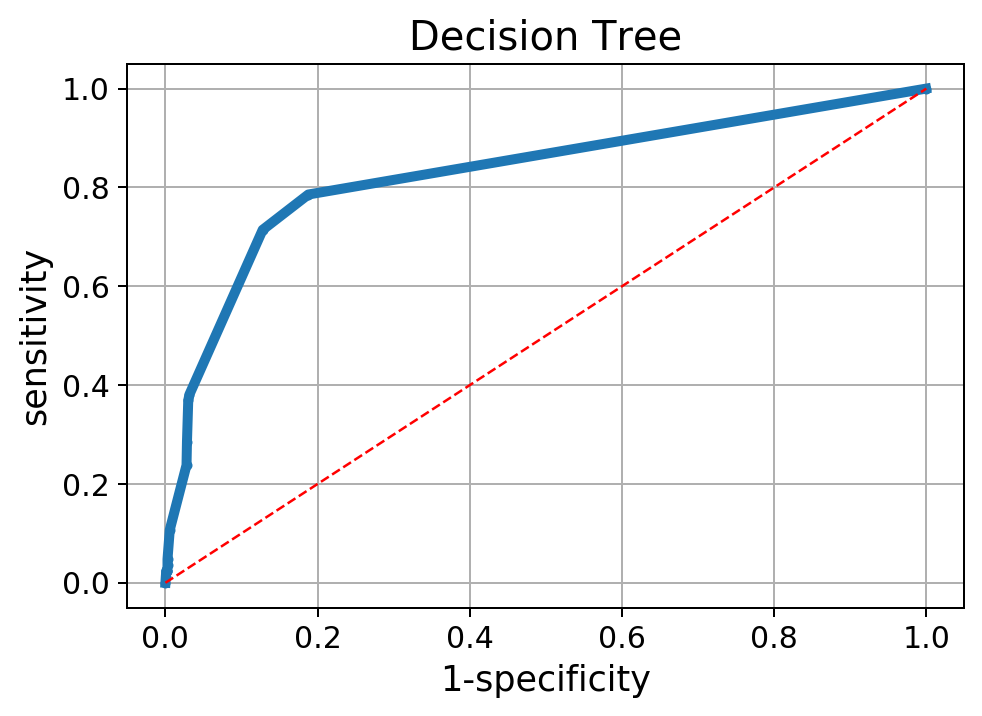

Feature Importances:

SFxBasHem      0.169
AMS            0.141
Hema           0.103
SFxPalp_No     0.076
SFxPalpDepress_Yes     0.057
HemaLoc_Parietal/Temporal     0.050
LocLen_1-5 min     0.050
VomitStart_Within 1 hr of event     0.041
LOCSeparate_Yes     0.039
HA_verb_Pre/Non-verbal     0.034


if (AMS <= 0.5)
 and (SFxBasHem <= 0.5)
 and (SFxPalpDepress_Yes <= 0.5)
 and (NeuroDMotor <= 0.5)
 and (HemaSize_Large <= 0.5)
 then
	 class: No ciTBI (prob: 99.76%) | 20,545 samples


if (AMS > 0.5)
 and (SFxBasHem <= 0.5)
 and (SFxPalp_No > 0.5)
 and (SeizLen_>15 min <= 0.5)
 and (High_impact_InjSev_High <= 0.5)
 then
	 class: No ciTBI (prob: 97.38%) | 2,553 samples


if (AMS <= 0.5)
 and (SFxBasHem <= 0.5)
 and (SFxPalpDepress_Yes <= 0.5)
 and (NeuroDMotor <= 0.5)
 and (HemaSize_Large > 0.5)
 then
	 class: No ciTBI (prob: 98.49%) | 1,459 samples


if (AMS > 0.5)
 and (SFxBasHem <= 0.5)
 and (SFxPalp_No > 0.5)
 and (SeizLen_>15 min <= 0.5)
 and (High_impact_InjSev_High > 0.5)
 then
	 class

In [46]:
# decision tree traversing func
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED 
                    else "Undefined!" for i in tree_.feature]
    paths = []
    path = []
    
    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)    
    samples_count = [p[-1][1] for p in paths]
    sorted_samples = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(sorted_samples)]
    rules = []
    for path in paths:
        rule = "if "
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            rule += '\n'
            
        rule += " then\n"
        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"\t class: {class_names[l]} (prob: {np.round(100 * classes[l] / np.sum(classes), 2)}%)"
        rule += f" | {path[-1][1]:,} samples\n\n"
        rules += [rule]
        
    return rules


def fit_eval_decTree(X_train, y_train, X_tune, y_tune, title_str, depth = list(range(1, 6)), weight_ratio = [1, 100]):
    '''
    Performs Decision Tree Algorithm
    
    input
    -------
    depth  : max_depth for decision trees
    weight_ratio : weight_ratio for non-tbi / tbi  (non-tbi : 1, tbi : weight_ratio)
    '''

    # Tuning the depth of the tree
    roc_tune = []
    acc_tune = []
    dep_iter = []
    wr_iter = []
    
    for dep in depth:
        for wr in weight_ratio :
            dt = DecisionTreeClassifier(max_depth = dep, class_weight = {0 : 1, 1 : wr})
            dt.fit(X_train, y_train)
            
            roc_tune.append(roc_auc_score(y_tune, dt.predict_proba(X_tune)[:, 1]))
            acc_tune.append(dt.score(X_tune, y_tune))
            dep_iter.append(dep)
            wr_iter.append(wr)

    # Find max_depth with best performance
    best_dep = dep_iter[np.argmax(np.array(roc_tune))]
    best_wr = wr_iter[np.argmax(np.array(roc_tune))]
    model = DecisionTreeClassifier(max_depth = best_dep, class_weight = {0 : 1, 1 : best_wr}).fit(X_train, y_train)
     
    # Print out the stats
    stats = predict_stats(model, X_tune, y_tune)
    stats['depth'] = best_dep
    stats['weight_ratio'] = best_wr
    stats['model_type'] = 'Decision Tree'
    
    plt.title(title_str)
    plt.show()
    
    return (model, stats)


# NOT USING TEST SET FOR THE MOMENT
'''
# use the depth 5
depth = 5
dt = DecisionTreeClassifier(max_depth=depth, class_weight={0: 1, 1:100})
dt.fit(X_train, y_train)
print(f'ROC of depth {depth}: {roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])}')
print(f'ACC of depth {depth}: {dt.score(X_test, y_test)}')
validation.all_stats_curve(y_test, dt.predict_proba(X_test)[:, 1], plot=True)
plt.title('ROC Curve of final Decision Tree on Test Set')
plt.show()
'''

dt, _ = fit_eval_decTree(X_train, y_train, X_tune, y_tune, 'Decision Tree', depth = list(range(1, 6)), weight_ratio = [1, 500])

# important features
print('Feature Importances:\n')
for col, val in sorted(zip(X_train.columns, dt.feature_importances_), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{col:10}{val:10.3f}')

# plotting decision tree
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names = X_train.columns, class_names = ['No ciTBI', 'ciTBI'], filled=True)

# plotting probabilities for the different possibilities
print('\n')
rules = get_rules(dt, X_train.columns, ['No ciTBI', 'ciTBI'])
for rule in rules:
    print(rule)

## SVM

In [47]:

def fit_eval_svm(X_train, y_train, X_tune, y_tune, title_str, gamma_vec = [2**(-2), 2**(-1.5), 2**(-1), 2**(-0.5), 1, 2**(1)]):
    '''
    Performs SVM
    
    input
    -------
    gamma  : hyperparameter to tune
    '''

    roc_tune = []
    acc_tune = []
    for c in gamma_vec:
        svm_v = svm.SVC(C = c, probability=True).fit(X_train, y_train)  # may add , class_weight = 'balanced'
        roc_tune.append(roc_auc_score(y_tune, svm_v.predict_proba(X_tune)[:, 1]))
        acc_tune.append(svm_v.score(X_tune, y_tune))

    # Find max_depth with best performance
    best_gamma = gamma_vec[np.argmax(np.array(roc_tune))]
    model = svm.SVC(C = best_gamma, probability=True).fit(X_train, y_train)
     
    # Print out the stats
    stats = predict_stats(model, X_tune, y_tune)
    stats['gamma'] = best_gamma
    stats['model_type'] = 'SVM'

    plt.title(title_str)
    plt.show()
    
    return (model, stats)
    

#fit_eval_svm(X_train, y_train, X_tune, y_tune, 'SVM')
    
# NOT USING TEST SET FOR THE MOMENT
'''
# Plot the result for the test set
validation.all_stats_curve(y_test, svm_final.predict_proba(X_test)[:, 1], plot = True)
plt.title('ROC curve for the final SVM model on test set')
plt.show()
'''

"\n# Plot the result for the test set\nvalidation.all_stats_curve(y_test, svm_final.predict_proba(X_test)[:, 1], plot = True)\nplt.title('ROC curve for the final SVM model on test set')\nplt.show()\n"

In [25]:
svm_final = svm.SVC(C=1, probability=True).fit(pd.concat([X_train], axis=0), np.hstack((y_train)))

# Print out the stats
predict_stats(y_tune, svm_final.predict_proba(X_tune)[:, 1], verbose = True)

Confusion Matrix : 
 [[  34   50]
 [1203 7199]]
Prob. threshold : 0.01442
AUC             : 0.644
Accuracy        : 0.852
Sensitivity     : 0.405
Specificity     : 0.857
Balanced Acc.   : 0.631
NPV             : 0.993


{'AUC': 0.6440742566962514,
 'Accuracy': 0.8523450388875795,
 'Balanced Accuracy': 0.6307908547851419,
 'Sensitivity': 0.40476190476190477,
 'Specificity': 0.8568198048083789,
 'NPV': 0.9931024968961236}

## Random Forest

In [35]:
def fit_eval_rf(X_train, y_train, X_tune, y_tune, title_str):
    '''
    Performs Random Forest

    '''
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Print out the stats
    stats = predict_stats(model, X_tune, y_tune)
    stats['model_type'] = 'Random Forest'
    
    plt.title(title_str)
    plt.show()
    
    return (model, stats)


    
rf, _ = fit_eval_rf(X_train, y_train, X_tune, y_tune, 'RF')
    
imps = rf.feature_importances_.round(3)
args = np.argsort(imps)
imps = imps[args]
feats = np.array(feature_names)[args]
for imp, feat in zip(imps, feats):
     print(feat, imp)

Confusion Matrix : 
 [[  51   33]
 [1030 7372]]
Prob. threshold : 0.00860
AUC             : 0.759
Accuracy        : 0.875
Sensitivity     : 0.607
Specificity     : 0.877
Balanced Acc.   : 0.742
NPV             : 0.996
Intubated 0.0
Paralyzed 0.0
FontBulg 0.002
InjuryMech_Walked/ran into stationary object 0.003
Sedated 0.004
InjuryMech_Fall to ground standing/walking/running 0.006
High_impact_InjSev_Low 0.007
InjuryMech_Fall down stairs 0.008
InjuryMech_Assault 0.009
InjuryMech_Bicyclist struck by automobile 0.009
InjuryMech_Bike collision/fall 0.01
InjuryMech_Sports 0.012
InjuryMech_Other wheeled crash 0.013
SFxPalp_Unclear 0.013
Drugs 0.016
SFxPalp_Yes 0.016
LOCSeparate_Suspected 0.017
InjuryMech_Object struck head - accidental 0.017
High_impact_InjSev_Moderate 0.018
InjuryMech_Pedestrian struck by moving vehicle 0.018
Seiz 0.02
SFxPalp_No 0.02
Amnesia_verb_Pre/Non-verbal 0.02
High_impact_InjSev_High 0.021
HA_verb_Pre/Non-verbal 0.021
InjuryMech_Other mechanism 0.021
NeuroD 0.022
Amne

# IT IS NOT INCLUDED IN MODELS AFTER THIS POINT

## Bayesian Rule List   - I just let simp_ exist

In [26]:
def simp_predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_simp_train, X_simp_tune],
                            [y_simp_train, y_simp_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BigDataRuleListClassifier(listlengthprior=2, max_iter=10000, class1label=1, verbose=False)
brl.fit(X_simp_train, y_simp_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


AttributeError: module 'imodels' has no attribute 'BigDataRuleListClassifier'

In [47]:
print(brl)

(Untrained RuleListClassifier)


## Rulefit

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 505.36it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

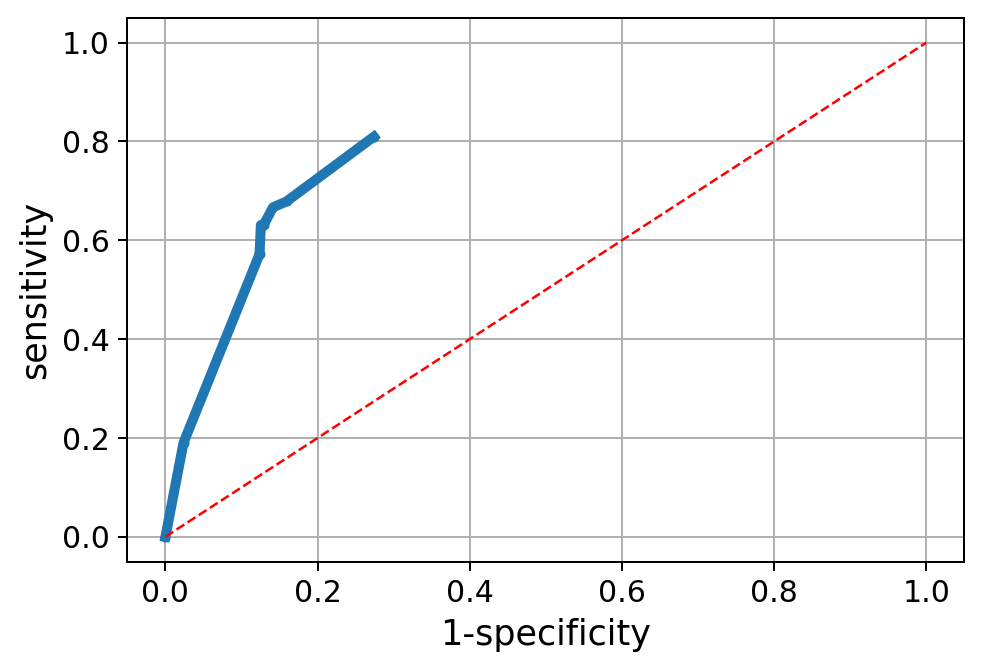

In [28]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)

feature_names = X_train.columns

rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [29]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
43,AMS <= 0.5 and SFxPalp_Yes <= 0.5,-0.00
46,AMS <= 0.5 and InjuryMech_Other wheeled crash <= 0.5,-0.00
44,AMS <= 0.5 and SFxPalp_No > 0.5,-0.02
45,High_impact_InjSev_High <= 0.5 and SFxPalp_Yes <= 0.5,-0.00


## Greedy (CART) Rule List

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 710.68it/s]


mean 0.009 (25458 pts)
if AMS >= 1 then 0.044 (3307 pts)
mean 0.004 (22151 pts)
if feat 34 >= 1 then 0.075 (80 pts)
mean 0.004 (22071 pts)
if feat 13 >= 1 then 0.011 (3151 pts)
mean 0.002 (18920 pts)
if feat 40 >= 1 then 0.039 (103 pts)
mean 0.002 (18817 pts)
if feat 9 >= 1 then 0.016 (386 pts)
mean 0.002 (18431 pts)
if feat 22 >= 1 then 0.016 (182 pts)
mean 0.002 (18249 pts)
if feat 18 >= 1 then 0.006 (1256 pts)
mean 0.001 (16993 pts)
if feat 36 >= 1 then 0.003 (6788 pts)
mean 0.0 (10205 pts)
if feat 6 >= 1 then 0.002 (1133 pts)



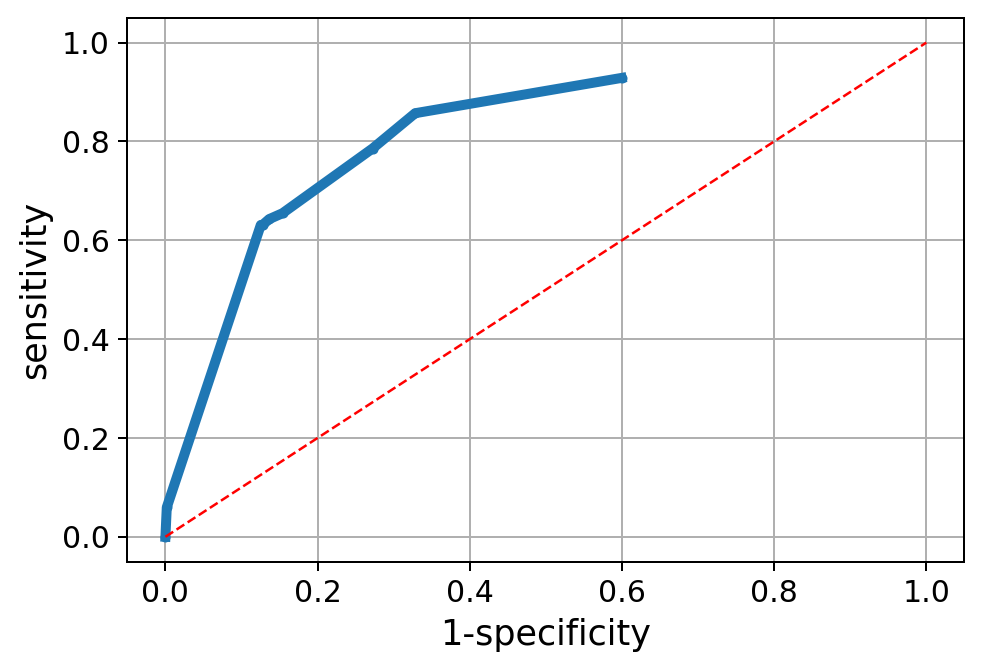

In [30]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

## Autogluon - autoML stuff, can't download it for some reason...

In [36]:
train_data = X_train
train_data['outcome'] = y_train
predictor = TabularPredictor(label='outcome').fit(train_data, presets='interpretable', time_limit=8, verbosity=2)

NameError: name 'TabularPredictor' is not defined

In [ ]:
predictor.leaderboard(silent=True)

In [ ]:
predictor.interpretable_models_summary()

In [ ]:
predictor.print_interpretable_rules()

# Analyze Results

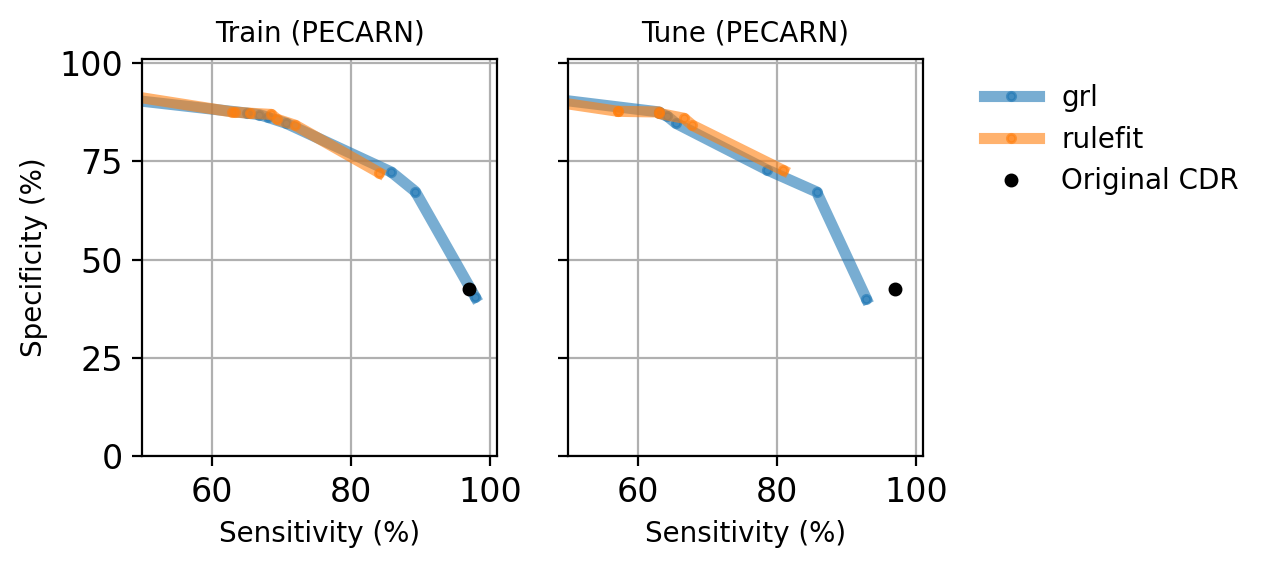

In [37]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

In [38]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 378.43it/s]


ValueError: X.shape[1] = 44 should be equal to 43, the number of features at training time. Please reshape your data.

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08
